**Operator Magic Method**

```python
Binary Operators:                Comparison Operators:        Assignment Operators:
+   __add__(self, other)         <   __lt__(self, other)      -=   __isub__(self, other)
–   __sub__(self, other)         >   __gt__(self, other)      +=   __iadd__(self, other)
*   __mul__(self, other)         <=  __le__(self, other)      *=   __imul__(self, other)
/   __truediv__(self, other)     >=  __ge__(self, other)      /=   __idiv__(self, other)
//  __floordiv__(self, other)    ==  __eq__(self, other)      //=  __ifloordiv__(self, other)
%   __mod__(self, other)         !=  __ne__(self, other)      %=   __imod__(self, other)
**  __pow__(self, other)                                      **=  __ipow__(self, other)
>>  __rshift__(self, other)                                   >>=  __irshift__(self, other)
<<  __lshift__(self, other)      Unary Operators:             <<=  __ilshift__(self, other)
&   __and__(self, other)         –   __neg__(self)            &=   __iand__(self, other)
|   __or__(self, other)          +   __pos__(self)            |=   __ior__(self, other)
^   __xor__(self, other)         ~   __invert__(self)         ^=   __ixor__(self, other)
```

In [1]:
import numpy as np
from matplotlib import pyplot as plt

class Tensor:
    def __init__(self, val, requires_grad=False, grad_fn=None, depends_on=[]):
        self.val = val
        self.requires_grad = requires_grad
        self.grad_fn = grad_fn
        self.depends_on = depends_on
        self.grad = 0
    
    def backward(self, grad=1):
        self.grad += grad
        
        for tensor, cache in self.depends_on:
            _grad = self.grad_fn(grad, tensor, cache)
            tensor.backward(_grad)
    
    # for +, python invoke the front object's __add__ in default
    def __add__(self, other):
        assert isinstance(other, (Tensor, int, float)), f"Unsupported Add between Tensor and {type(other)}."
        
        depends_on = []
        grad_fn = AddBackward
        requires_grad = self.requires_grad
        if self.requires_grad:
            depends_on.append((self, []))
            
        if isinstance(other, Tensor):
            val = self.val + other.val
            requires_grad = requires_grad or other.requires_grad
            if other.requires_grad:
                depends_on.append((other, []))
        else:
            val = self.val + other
        
        return Tensor(val, requires_grad, grad_fn, depends_on)
    
    # if the front object's __add__ is not supported for this +, then python invoke second object's __radd__
    def __radd__(self, other):
        return self.__add__(other)
    
    def __sub__(self, other):
        assert isinstance(other, (Tensor, int, float)), f"Unsupported Sub between Tensor and {type(other)}."
        
        depends_on = []
        grad_fn = SubBackward
        requires_grad = self.requires_grad
        
        if self.requires_grad:
            depends_on.append((self, [1])) # 1 indicates left val
        
        if isinstance(other, Tensor):
            val = self.val - other.val
            requires_grad = requires_grad or other.requires_grad
            if other.requires_grad:
                depends_on.append((other, [-1])) # -1 indicates right val
        else:
            val = self.val - other
        
        return Tensor(val, requires_grad, grad_fn, depends_on)
    
    def __rsub__(self, other):
        """Do not just use unary minus for avoiding adding a new tensor in backward chain"""
        assert isinstance(other, (int, float)), f"Unsupported Sub between {type(other)} and Tensor."
        
        depends_on = []
        grad_fn = SubBackward
        requires_grad = self.requires_grad
        
        val = other - self.val
        if self.requires_grad:
            depends_on.append((self, [-1])) # -1 indicates right val
        
        return Tensor(val, requires_grad, grad_fn, depends_on)
    
    def __mul__(self, other):
        assert isinstance(other, (Tensor, int, float)), f"Unsupported Mul between Tensor and {type(other)}."
        
        depends_on = []
        grad_fn = MulBackward
        requires_grad = self.requires_grad
        
        if isinstance(other, Tensor):
            val = self.val * other.val
            requires_grad = requires_grad or other.requires_grad
            if self.requires_grad:
                depends_on.append((self, [other.val]))
            
            if other.requires_grad:
                depends_on.append((other, [self.val]))
        else:
            val = self.val * other
            if self.requires_grad:
                depends_on.append((self, [other])) # cache another value for derivative
        
        return Tensor(val, requires_grad, grad_fn, depends_on)
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __pow__(self, power):
        assert isinstance(power, (int, float)), f"Unsupported Pow between Tensor and {type(other)}."
        
        depends_on = []
        grad_fn = PowBackward
        requires_grad = self.requires_grad
        
        val = np.power(self.val, power)
        if self.requires_grad:
            depends_on.append((self, [power]))
            
        return Tensor(val, requires_grad, grad_fn, depends_on)
    
    def __neg__(self):
        depends_on = []
        grad_fn = NegBackward
        requires_grad = self.requires_grad
        
        val = -self.val
        if self.requires_grad:
            depends_on.append((self, [-1]))
        
        return Tensor(val, requires_grad, grad_fn, depends_on)
    
    def exp(self):        
        depends_on = []
        grad_fn = ExpBackward
        requires_grad = self.requires_grad
        
        val = np.exp(self.val)
        if self.requires_grad:
            depends_on.append((self, [val]))
            
        return Tensor(val, requires_grad, grad_fn, depends_on)
    
    def __lt__(self, other):
        assert isinstance(other, (Tensor, int, float)), f"Unsupported '<' between Tensor and {type(other)}."
        
        return self.val < (other.val if isinstance(other, Tensor) else other)
    
    def __gt__(self, other):
        assert isinstance(other, (Tensor, int, float)), f"Unsupported '>' between Tensor and {type(other)}."
        
        return self.val > (other.val if isinstance(other, Tensor) else other)
    
def AddBackward(grad, tensor, cache):
    return grad * np.ones_like(tensor.val)

def SubBackward(grad, tensor, cache):
    """grad * cache[0] == grad * np.ones_like(tensor.val) * cache[0]"""
    return grad * np.ones_like(tensor.val) * cache[0]

def MulBackward(grad, tensor, cache):
    return grad * cache[0]

def PowBackward(grad, tensor, cache):
    power = cache[0]
    return grad * power * np.power(tensor.val, power-1)

def NegBackward(grad, tensor, cache):
    """grad * cache[0] == grad * np.ones_like(tensor.val) * cache[0]"""
    return grad * np.ones_like(tensor.val) * cache[0]

def ExpBackward(grad, tensor, cache):
    """cache[0] == np.exp(tensor.val)"""
    return grad * cache[0]

**Helper Function**

In [2]:
def plot(x, y=[], title=None):
    if title:
        plt.title(title) 
    if y:
        for line in y:
            plt.plot(x, line[0], label=line[1])
    else:
        plt.plot(x)
    plt.grid(True)
    plt.legend()
    plt.show()

**Draw Ricker Wavelet Function**

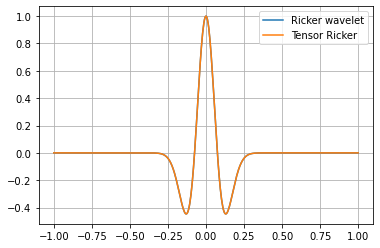

In [3]:
# Params
f = 3
pi = 3.14
precision = 500
# Domain
t = np.linspace(-1, 1, precision)

# Ricker wavelet function
ricker = (1-2*(pi*f*t)**2)*np.exp(-(pi*f*t)**2)

# Ricker wavelet function with autograd, which should be the same as above function
v_t = Tensor(t, requires_grad=True)
v_ricker = (1-2*(pi*f*v_t)**2)*(-(pi*f*v_t)**2).exp()
v_ricker.backward() # get first derivative

plot(t, [(ricker, 'Ricker wavelet'), (v_ricker.val, 'Tensor Ricker')])

**Plot 3 types of derivatives**

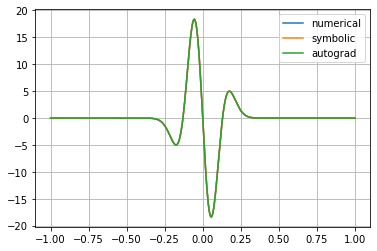

In [4]:
# numerical differentiation
delta_t = t[1]-t[0]
nd_ricker = np.zeros(precision)
nd_ricker[1:-1] = (ricker[2::]-ricker[0:-2])/(2*delta_t)

# symbolic derivation
sd_ricker = 2*f**2*pi**2*t*(2*f**2*pi**2*t**2-3)*np.exp(-f**2*pi**2*t**2)

# autograd
autograd = v_t.grad

# all above should be approximately the same, but numerical derivative would cause a little error
plot(t,[(nd_ricker, 'numerical'), (sd_ricker, 'symbolic'), (autograd, 'autograd')])

**Compare symbolic (accurate value) with the other two**

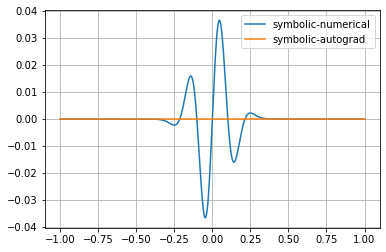

In [5]:
plot(t, [(nd_ricker-sd_ricker, 'symbolic-numerical'), (v_t.grad-sd_ricker, 'symbolic-autograd')])